In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import skimage.morphology as morph
import skimage.filters as filters
import skimage.exposure as exposure
from skimage.feature import graycomatrix, graycoprops
import skimage.feature as feature
import skimage.segmentation as seg
import os

In [16]:
def processing(img):
    # img = cv2.resize(img, (500, 500))
    # green channel
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, mg = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY_INV)
    reverse = cv2.bitwise_not(mg)
    contours, hierarchy = cv2.findContours(reverse, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    select = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(select)
    png = img[y:y+h, x:x+w]
    # png = cv2.resize(png, (500, 500))
    green = png[:, :, 1]
    clahe = exposure.equalize_adapthist(green, clip_limit=0.03)
    canny = feature.canny(clahe, sigma=2.0, low_threshold=0.05, high_threshold=0.1)
    # flood filling
    flood = seg.flood_fill(canny, (1, 1), 255, connectivity=2)

    return flood

In [45]:
import cv2
import numpy as np

# read the image
# img = cv2.imread('retina_eye.jpg')

def blood(img):
    # convert to GREEN
    gray = img[:, :, 1]

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    gray = clahe.apply(gray)

    # apply morphology
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT , (5,5))
    morph = cv2.morphologyEx(gray, cv2.MORPH_DILATE, kernel)

    # divide gray by morphology image
    division = cv2.divide(gray, morph, scale=255)

    # threshold
    thresh = cv2.threshold(division, 0, 255, cv2.THRESH_OTSU )[1] 

    # invert
    thresh = 255 - thresh

    # find contours and discard contours with small areas
    mask = np.zeros_like(thresh)
    contours = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if len(contours) == 2 else contours[1]

    area_thresh = 10000
    for cntr in contours:
        area = cv2.contourArea(cntr)
        if area > area_thresh:
            cv2.drawContours(mask, [cntr], -1, 255, 2)

    # apply mask to thresh
    result1 = cv2.bitwise_and(thresh, mask)
    mask = cv2.merge([mask,mask,mask])
    result2 = cv2.bitwise_and(img, mask)
    return result2

In [6]:
def extractExudate(img):
  # green channel
  green = img[:, :, 1]
  # clahe
  clahe = cv2.createCLAHE()
  green = clahe.apply(green)
  # dilation
  kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (6, 6))
  dilate = cv2.dilate(green, kernel)
  # threshold
  val, thresh = cv2.threshold(dilate, 220, 220, cv2.THRESH_BINARY)
  # median filter
  median = cv2.medianBlur(thresh, 5)

  return median

In [4]:
def crop_image_from_gray(img,tol=7):
  if img.ndim ==2:
    mask = img>tol
    return img[np.ix_(mask.any(1),mask.any(0))]
  elif img.ndim==3:
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    mask = gray_img>tol        
    check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
    if (check_shape == 0):
        return img
    else:
      img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
      img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
      img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
      img = np.stack([img1,img2,img3],axis=-1)
      return img

def circle_crop_v2(img):
  img = crop_image_from_gray(img)

  height, width, depth = img.shape
  largest_side = np.max((height, width))
  img = cv2.resize(img, (largest_side, largest_side))

  height, width, depth = img.shape

  x = int(width / 2)
  y = int(height / 2)
  r = np.amin((x, y))

  circle_img = np.zeros((height, width), np.uint8)
  cv2.circle(circle_img, (x, y), int(r), 1, thickness=-1)
  img = cv2.bitwise_and(img, img, mask=circle_img)
  img = crop_image_from_gray(img)

  return img

In [2]:
def altSeqFilter(img):
  kernels = [(5,5), (7,7), (15,15), (11,11)]
  img_close=img.copy()
  for alt_seq in range(4):
    img_open = cv2.morphologyEx(img_close, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,kernels[alt_seq]), iterations = 1)
    img_close = cv2.morphologyEx(img_open, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,kernels[alt_seq]), iterations = 1)
  return img_close

In [6]:
def getContours1(img, thresh):
  mask1 = np.ones(img.shape, dtype="uint8") * 255	
  cnts0, hier0 = cv2.findContours(img.copy(),cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
  for i in cnts0:
    if cv2.contourArea(i) <= thresh:
      cv2.drawContours(mask1, [i], -1, 0, 1)
  mask1 = cv2.bitwise_and(img, img, mask = mask1)
  return mask1

In [7]:
def preprocessing(img):
  green = img[:, :, 1]
  green[green<30] = 0
  clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(3,3))
  green = clahe.apply(green)
  alt = altSeqFilter(green)
  sub = cv2.subtract(alt, green)
  clahe2 = cv2.createCLAHE(clipLimit=16.0, tileGridSize=(2,2))
  imclahe2 = clahe2.apply(sub)

  mdf = cv2.medianBlur(cv2.GaussianBlur(imclahe2, (3,3), 0), 3)
  _, tresh = cv2.threshold(mdf, 30, 255, cv2.THRESH_BINARY)
  clth = getContours1(tresh, 8)
  clth = getContours1(clth, 1)
  return clth

In [10]:
def glcm(img):
    glcm_feature = ['contrast', 'dissimilarity', 'homogeneity', 'ASM', 'energy', 'correlation']
    distance = [5]
    angles = [0]
    level = 256
    symetric = True
    normed = True

    glcm = graycomatrix(img, distance, angles, level, symmetric=symetric, normed=normed)
    glcm_props = [property for name in glcm_feature for property in graycoprops(glcm, name)[0]]

    return glcm_props

[[[7405.684318555008, 29.041899288451013, 0.8861119503190262, 0.6913412697813525, 0.8314693438614273, 0.4517671027881205], [1129.2411146716297, 4.428396528124038, 0.9826340061718138, 0.9587227134749569, 0.9791438676083085, 0.2827597274550483], [5668.935794527409, 22.231120762852584, 0.9128204749711284, 0.7766571356151838, 0.8812815302814327, 0.3935771531199186], [8130.658441558441, 31.884935064935064, 0.8749629618681998, 0.655324445874312, 0.8095211213268694, 0.468532955317263], [7024.8591954022995, 27.548467432950194, 0.8919684557653509, 0.6985460445383951, 0.8357906702867621, 0.47324495352984347]], [[9214.85337845279, 36.136679915501134, 0.858289709063255, 0.710174399356405, 0.8427184579421558, 0.15745412782813376], [9280.190472567987, 36.392903813992106, 0.857284924913604, 0.688161955898903, 0.8295552759755693, 0.24683081940823698], [10378.24744410166, 40.6990095847124, 0.8403984953080053, 0.621410113744235, 0.7882957019699112, 0.34711452606594645], [8824.924778672503, 34.6075481516

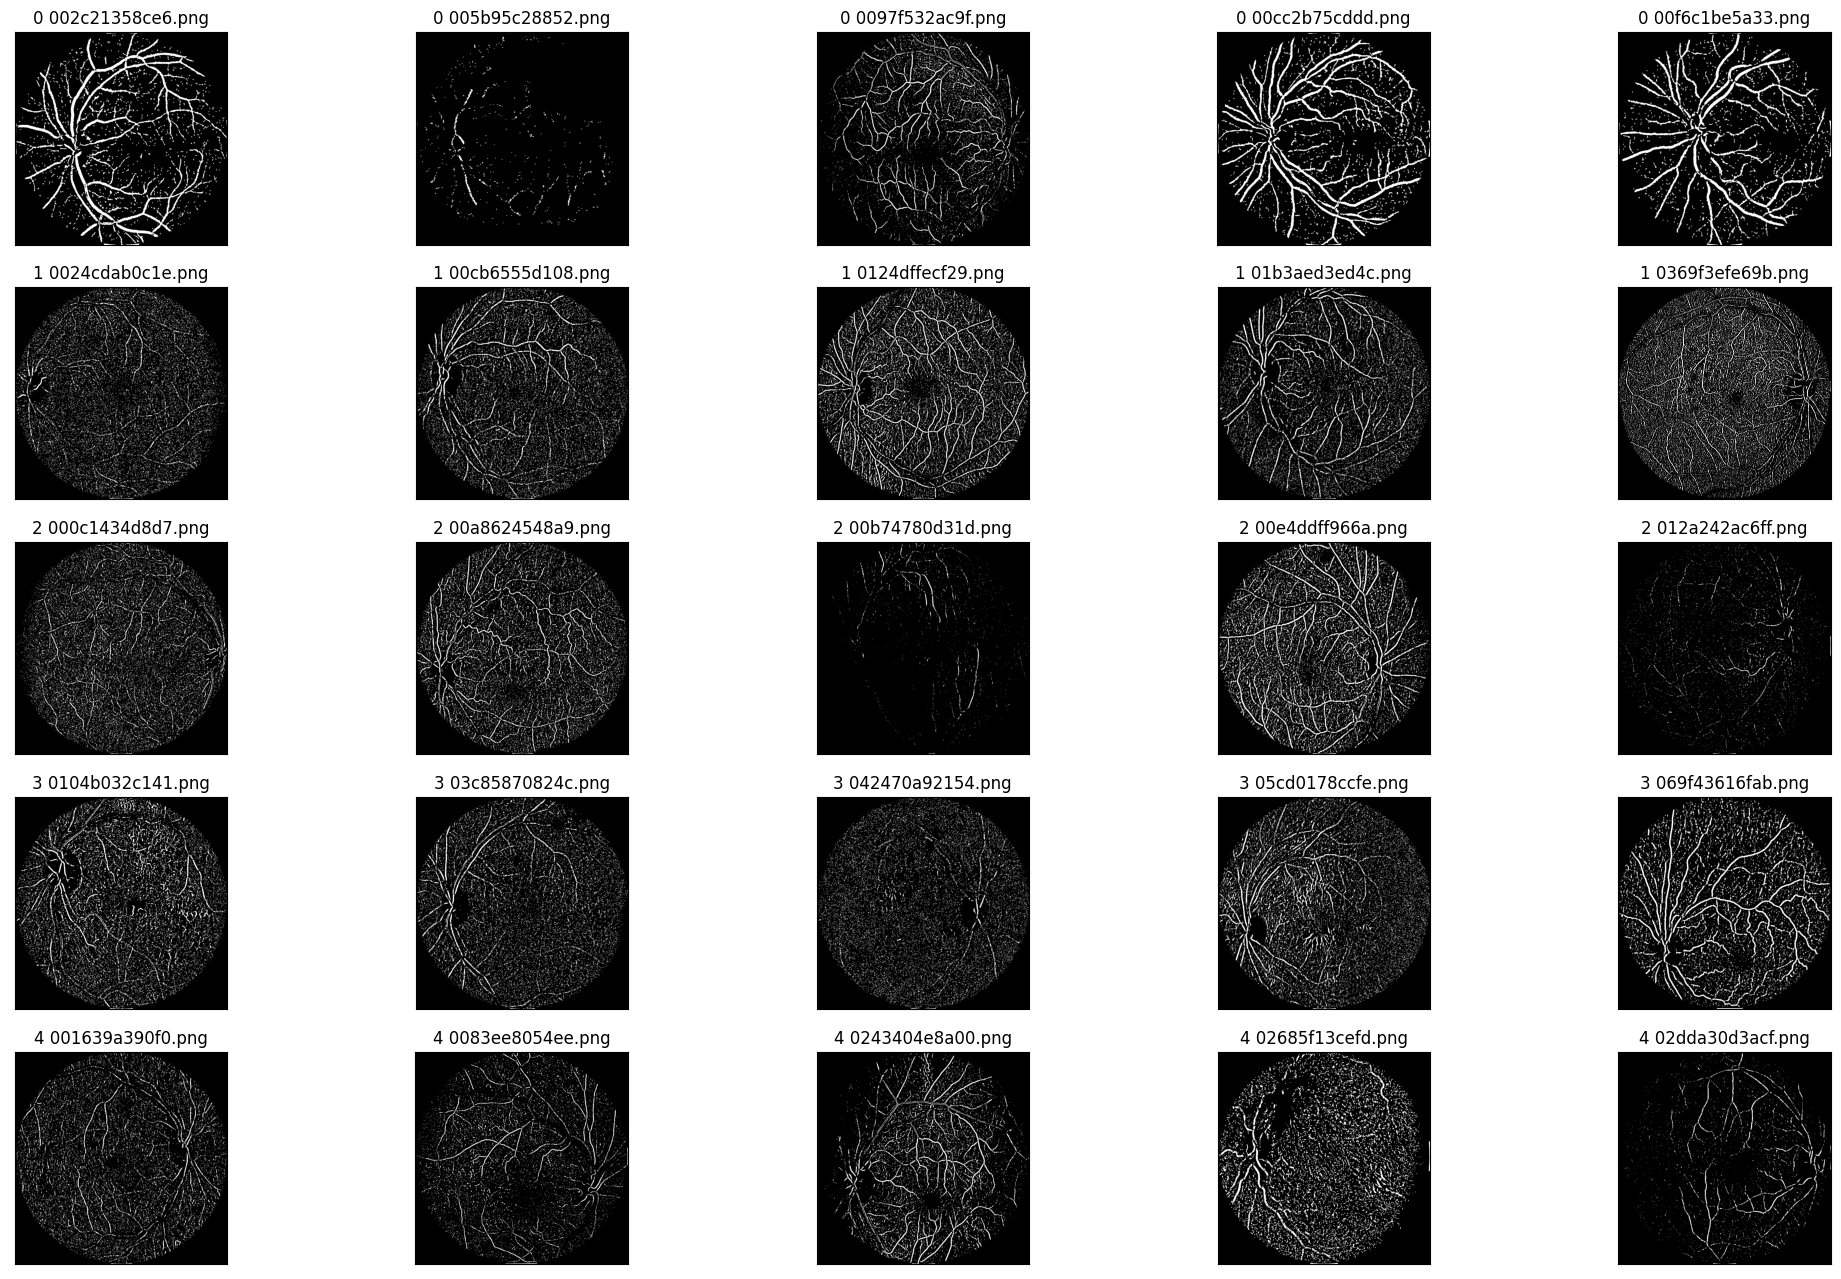

In [12]:
path_dataset = 'E:/Pawang Code/Diabetic Retinopathy/dataset'
fig = plt.figure(figsize=(25, 16))
j= 0
temp = []
for folder in os.listdir(path_dataset):
    sub_folder_files = os.listdir(os.path.join(path_dataset, folder))
    temp2 = []
    for i, filename in enumerate(sub_folder_files):
        ax = fig.add_subplot(5, 5, j+1, xticks=[], yticks=[])
        img = cv2.imread(os.path.join(path_dataset, folder, filename))
        img = circle_crop_v2(img)
        img = preprocessing(img)
        plt.imshow(img, cmap='gray')
        ax.set_title(folder + ' ' + filename)
        temp2.append(glcm(img))
        j += 1
        if i == 4:
            break
    temp.append(temp2)

# print(temp)

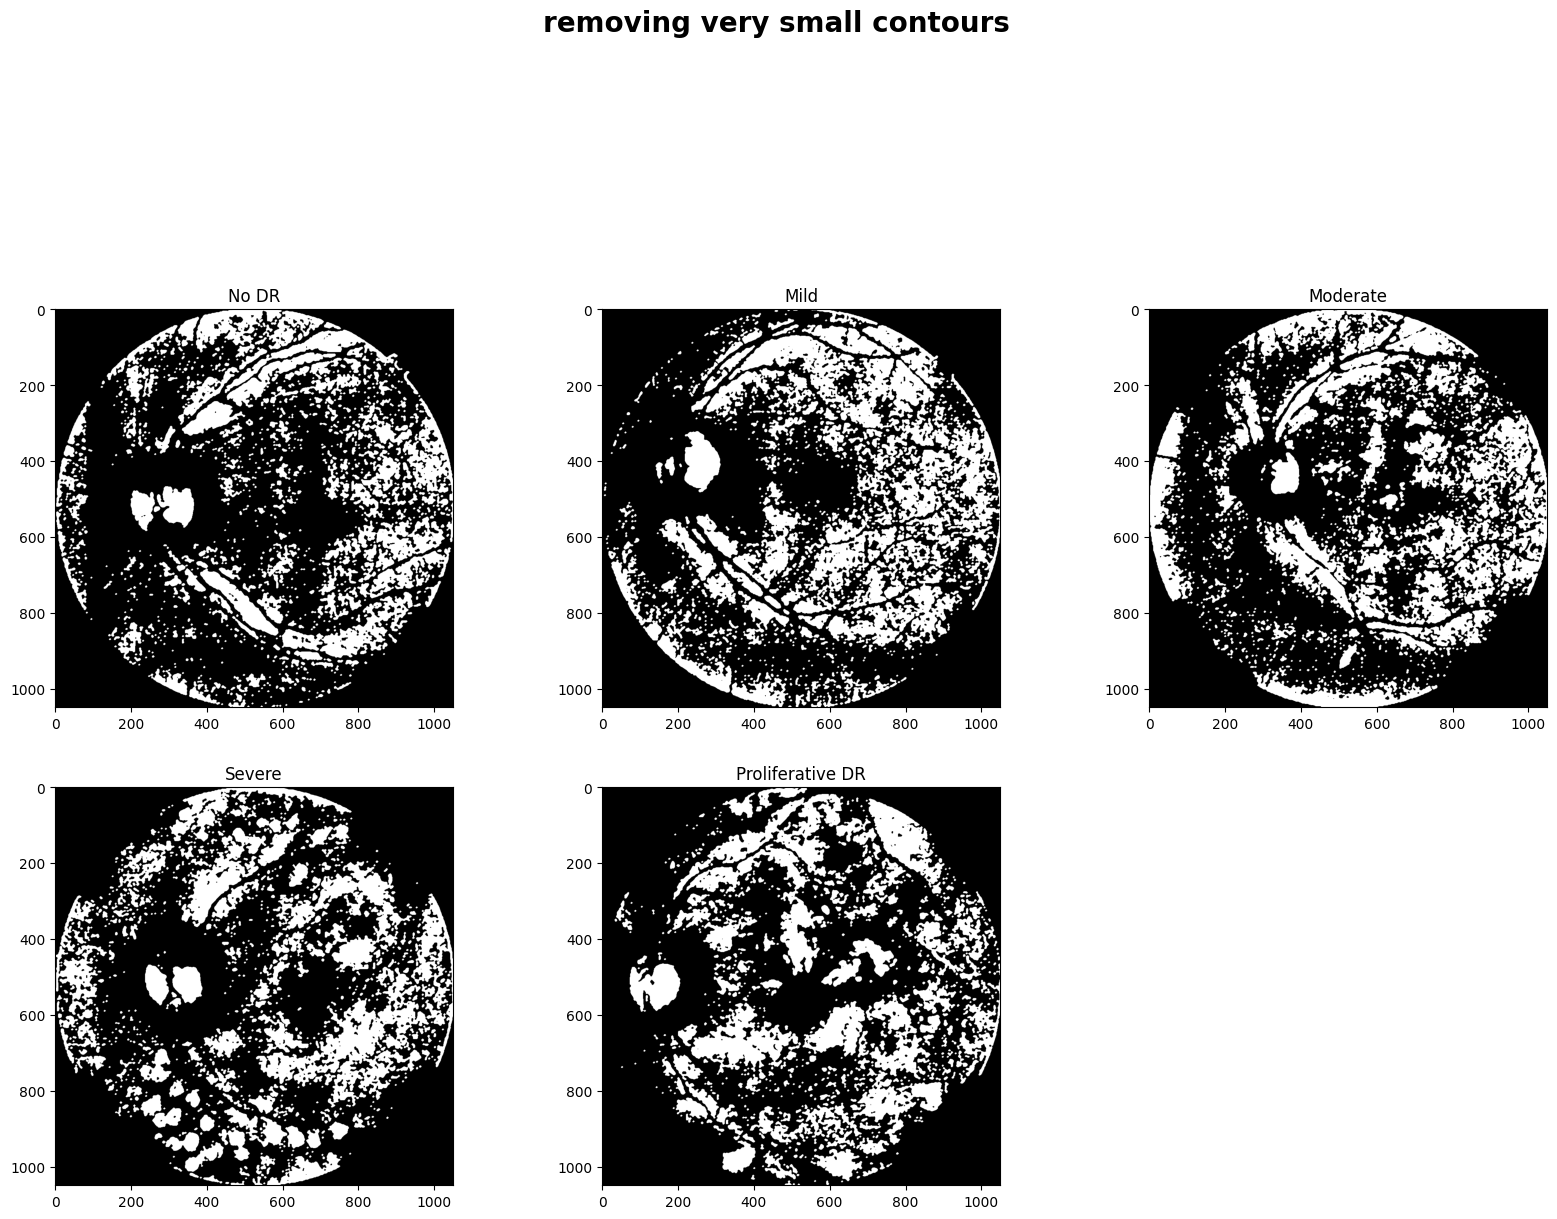

In [9]:
img0 = cv2.imread('E:/Pawang Code/Diabetic Retinopathy/dataset/0/00cc2b75cddd.png')
img1 = cv2.imread('E:/Pawang Code/Diabetic Retinopathy/dataset/1/38e0e28d35d3.png')
img2 = cv2.imread('E:/Pawang Code/Diabetic Retinopathy/dataset/2/3f5b4c2948e8.png')
img3 = cv2.imread('E:/Pawang Code/Diabetic Retinopathy/dataset/3/8688f3d0fcaf.png')
img4 = cv2.imread('E:/Pawang Code/Diabetic Retinopathy/dataset/4/613028ede6a0.png')

# img0 = cv2.cvtColor(img0, cv2.COLOR_BGR2RGB)
# img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
# img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
# img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)
# img4 = cv2.cvtColor(img4, cv2.COLOR_BGR2RGB)

img0 = extractExudate(img0)
img1 = extractExudate(img1)
img2 = extractExudate(img2)
img3 = extractExudate(img3)
img4 = extractExudate(img4)

# cv2.imshow('img0', img0)
# cv2.imshow('img1', img1)
# cv2.imshow('img2', img2)
# cv2.imshow('img3', img3)
# cv2.imshow('img4', img4)

# cv2.waitKey(0)
# cv2.destroyAllWindows()

plt.figure(figsize=(20, 30))
plt.suptitle('removing very small contours', fontsize=20, fontweight='bold')
plt.subplot(5, 3, 1)
plt.title('No DR')
plt.imshow(img0, cmap='gray')
plt.subplot(5, 3, 2)
plt.title('Mild')
plt.imshow(img1, cmap='gray')
plt.subplot(5, 3, 3)
plt.title('Moderate')
plt.imshow(img2, cmap='gray')
plt.subplot(5, 3, 4)
plt.title('Severe')
plt.imshow(img3, cmap='gray')
plt.subplot(5, 3, 5)
plt.title('Proliferative DR')
plt.imshow(img4, cmap='gray')

In [11]:
glcm0 = glcm(img0)
glcm1 = glcm(img1)
glcm2 = glcm(img2)
glcm3 = glcm(img3)
glcm4 = glcm(img4)

print(glcm0)
print(glcm1)
print(glcm2)
print(glcm3)
print(glcm4)

[7224.733834586467, 32.839699248120304, 0.8507317238365641, 0.5008107767436364, 0.7076798546967664, 0.5989483083845525]
[7987.621052631579, 36.30736842105263, 0.8349699168894945, 0.43106744607495245, 0.6565572679324725, 0.6172116648900042]
[7652.382957393484, 34.78355889724311, 0.8418961807112769, 0.4487072951140668, 0.6698561749465827, 0.6219193311305126]
[6965.9388471177945, 31.663358395989977, 0.8560786172368795, 0.4832734709662992, 0.6951787331084713, 0.6342608366721615]
[6359.510776942356, 28.9068671679198, 0.868607863950283, 0.4899520731649543, 0.6999657657092626, 0.6681258341182258]
